<a href="https://colab.research.google.com/github/yiit8/ACSE-Framework/blob/main/BIRDS400_MULTICLASS_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
torchvision.__version__, torch.__version__

('0.12.0+cu113', '1.11.0+cu113')

In [2]:
import numpy as np
import pandas as pd 
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import albumentations as A
import cv2

In [3]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yigitgun","key":"ebf933a5306c1641041ee1e635f3d4f7"}'}

In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download "gpiosenka/100-bird-species"


100% 1.49G/1.49G [00:10<00:00, 164MB/s]
100% 1.49G/1.49G [00:10<00:00, 149MB/s]


In [10]:
!unzip "/content/100-bird-species.zip" -d "/content/100-bird-species"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/102.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/103.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/104.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/105.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/106.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/107.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/108.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/109.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/110.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/111.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/112.jpg  
  inflating: /content/100-bird-species/train/VERMILION FLYCATHER/113.jpg  
  inflating: /content/100-bird-species/train/VERMILIO

In [11]:
dataset_path = "/content/100-bird-species"

class_dict = pd.read_csv(os.path.join(dataset_path, "class_dict.csv"))

classes = list(class_dict['class'])
print(len(classes))

400


In [46]:
def get_data_loaders(data_dir, batch_size=64, train = False):
    if train:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(), 
                                                        transforms.GaussianBlur(3)]), p=0.1),
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.RandomErasing(p=0.14, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        print(f"Found {len(train_data)} images for training with {len(train_data.classes)} classes")
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        return train_loader, len(train_data)
    
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)
        print(f"Found {len(val_data)} images for validation with {len(val_data.classes)} classes")
        print(f"Found {len(test_data)} images for testing with {len(test_data.classes)} classes")
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        return (val_loader, test_loader, len(val_data), len(test_data))

In [47]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 256, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 64, train=False)

Found 58388 images for training with 400 classes
Found 2000 images for validation with 400 classes
Found 2000 images for testing with 400 classes


In [ ]:
/content/100-bird-species
/content/100-bird-species/test

In [48]:
dataloaders = {
    "train":train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train":train_data_len,
    "val": valid_data_len
}

In [49]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

229
32
32


In [50]:
print(train_data_len, test_data_len, valid_data_len)

58388 2000 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

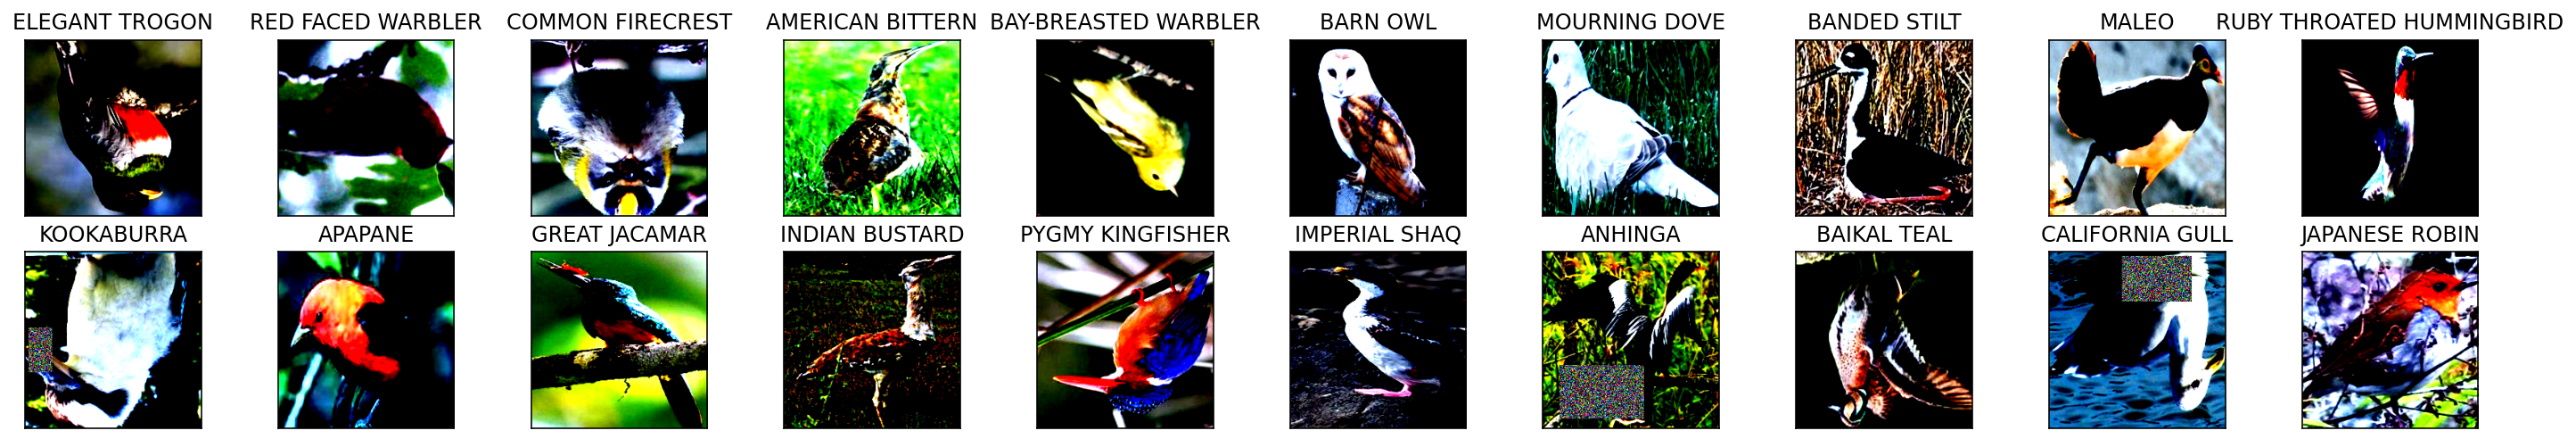

In [51]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
# MODEL
torch.backends.cudnn.benchmark = True
model = models.efficientnet_b1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(classes))
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=400, bias=True)
)


In [54]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [55]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm
import time
import copy

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [56]:
# TRAIN
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                 # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [57]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


100%|██████████| 229/229 [04:11<00:00,  1.10s/it]


train Loss: 2.9681 Acc: 0.5787


100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


val Loss: 1.6512 Acc: 0.8970

Epoch 1/4
----------


100%|██████████| 229/229 [04:12<00:00,  1.10s/it]


train Loss: 1.9567 Acc: 0.8080


100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


val Loss: 1.4941 Acc: 0.9345

Epoch 2/4
----------


100%|██████████| 229/229 [04:14<00:00,  1.11s/it]


train Loss: 1.7817 Acc: 0.8561


100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


val Loss: 1.4459 Acc: 0.9475

Epoch 3/4
----------


100%|██████████| 229/229 [04:11<00:00,  1.10s/it]


train Loss: 1.6281 Acc: 0.9013


100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


val Loss: 1.3822 Acc: 0.9635

Epoch 4/4
----------


100%|██████████| 229/229 [04:03<00:00,  1.06s/it]


train Loss: 1.5749 Acc: 0.9143


100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

val Loss: 1.3700 Acc: 0.9600

Training complete in 21m 32s
Best val Acc: 0.963500


In [42]:
# TEST
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [58]:
test(model_ft)

100%|██████████| 32/32 [00:07<00:00,  4.35it/s]

Test Loss: 1.341477

Test Accuracy of ABBOTTS BABBLER: 75% ( 3/ 4)
Test Accuracy of ABBOTTS BOOBY: 60% ( 3/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 100% ( 5/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 100% ( 5/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 100% ( 5/ 5)
Test Accuracy of ALPINE CHOUGH: 100% ( 5/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 60% ( 3/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 5)
Test Accuracy of AMERICAN REDSTART: 100% ( 5/ 5)
Test Accuracy of AMETHYST WOODSTAR: 100% ( 5/ 5)
Tes

In [59]:
torch.save(model.state_dict(), "/content/100-bird-species/100BIRD.pth")